# East coast floods


In [1]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import general_utils
from unseen import time_utils
from unseen import indices

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
agcd_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_add_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-additive.zarr.zip"
model_mulc_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_add_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-additive.zarr.zip"
similarity_mulc_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region_AGCD-CSIRO.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/east-coast-rain/figures/independence-test_Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region.png"
model_name = "CanESM5"
min_lead = 1
region_name = "east-coast-flood-region"
shape_file = "/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp"
file_list = (
    "/home/599/dbi599/east-coast-rain/file_lists/CanESM5_dcppA-hindcast_pr_files.txt"
)
nino_file = "/g/data/xv83/dbi599/east-coast-rain/data/nino34-anomaly_CanESM5-dcppA-hindcast_196101-201701_base-196101-201701.nc"


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p model_file [filepath])"
assert os.path.isfile(model_add_bc_file), "Must provide a model additive bias corrected data file (papermill option -p model_add_bc_file [filepath])"
assert os.path.isfile(model_mulc_bc_file), "Must provide a model multiplicative bias corrected data file (papermill option -p model_mulc_bc_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a model Nino 3.4 data file (papermill option -p nino_file [filepath])"
assert os.path.isfile(similarity_add_bc_file), "Must provide an additive bias corrected similarity test file (papermill option -p similarity_add_bias_file [filepath])"
assert os.path.isfile(similarity_mulc_bc_file), "Must provide an multiplicative bias corrected similarity test file (papermill option -p similarity_mulc_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [5]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [6]:
agcd_ds

<xarray.Dataset>
Dimensions:     (time: 122)
Coordinates:
    event_time  (time) <U28 dask.array<chunksize=(122,), meta=np.ndarray>
  * time        (time) object 1901-01-01 09:00:00 ... 2022-01-01 09:00:00
Data variables:
    pr          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [7]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [8]:
pr2022 = agcd_ds['pr'].values.max()
print(pr2022)

410.43057


## Model ensemble

### Region selection

In [9]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [10]:
first_file

'/g/data/oi10/replicas/CMIP6/DCPP/CCCma/CanESM5/dcppA-hindcast/s1960-r1i1p2f1/day/pr/gn/v20190429/pr_day_CanESM5_dcppA-hindcast_s1960-r1i1p2f1_gn_19610101-19701231.nc'

In [11]:
shapes = gp.read_file(shape_file)

In [12]:
isel_dict = {}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/home/599/dbi599/unseen/config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [13]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=['pr'],
    lat_bnds=[-40, -20],
    lon_bnds=[140, 160],
    shapefile=shape_file,
    shape_overlap=0.1,
    units={'pr': 'mm day-1'},
    isel=isel_dict,
)

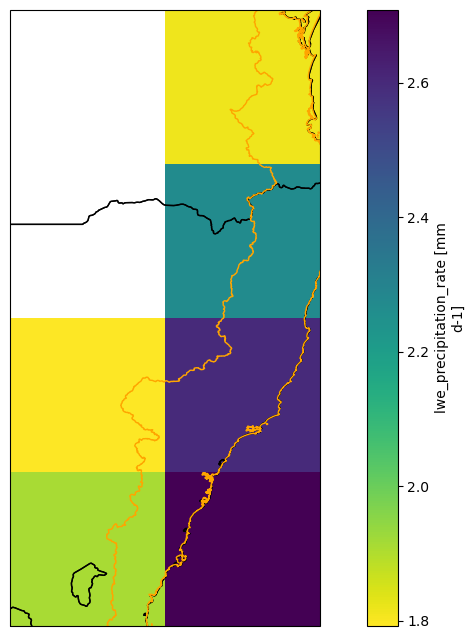

In [14]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds['pr'].mean('time', keep_attrs=True).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [15]:
model_ds = fileio.open_dataset(model_file)
model_add_bc_ds = fileio.open_dataset(model_add_bc_file)
model_mulc_bc_ds = fileio.open_dataset(model_mulc_bc_file)

In [16]:
model_ds

<xarray.Dataset>
Dimensions:     (ensemble: 20, init_date: 57, lead_time: 11)
Coordinates:
  * ensemble    (ensemble) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
    event_time  (init_date, ensemble, lead_time) <U28 dask.array<chunksize=(57, 20, 11), meta=np.ndarray>
  * init_date   (init_date) object 1961-01-01 00:00:00 ... 2017-01-01 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time        (lead_time, init_date) object dask.array<chunksize=(11, 57), meta=np.ndarray>
Data variables:
    pr          (init_date, ensemble, lead_time) float64 dask.array<chunksize=(1, 1, 11), meta=np.ndarray>
Attributes: (12/53)
    CCCma_model_hash:            Unknown
    CCCma_parent_runid:          d2a-asm-e01
    CCCma_pycmor_hash:           13db8596c37129e414cad7ae31f2927ca8f5dd39
    CCCma_runid:                 d2a196101e01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1961:01:01:00
    ...                          ...
    table_info:                  Creation Date:(20 February 2019) MD5:374fbe5...
    title:                       CanESM5 output prepared for CMIP6
    tracking_id:                 hdl:21.14100/f220e01c-1214-4625-be6a-c0475c2...
    variable_id:                 pr
    variant_label:               r1i1p2f1
    version:                     v20190429

### Independence testing

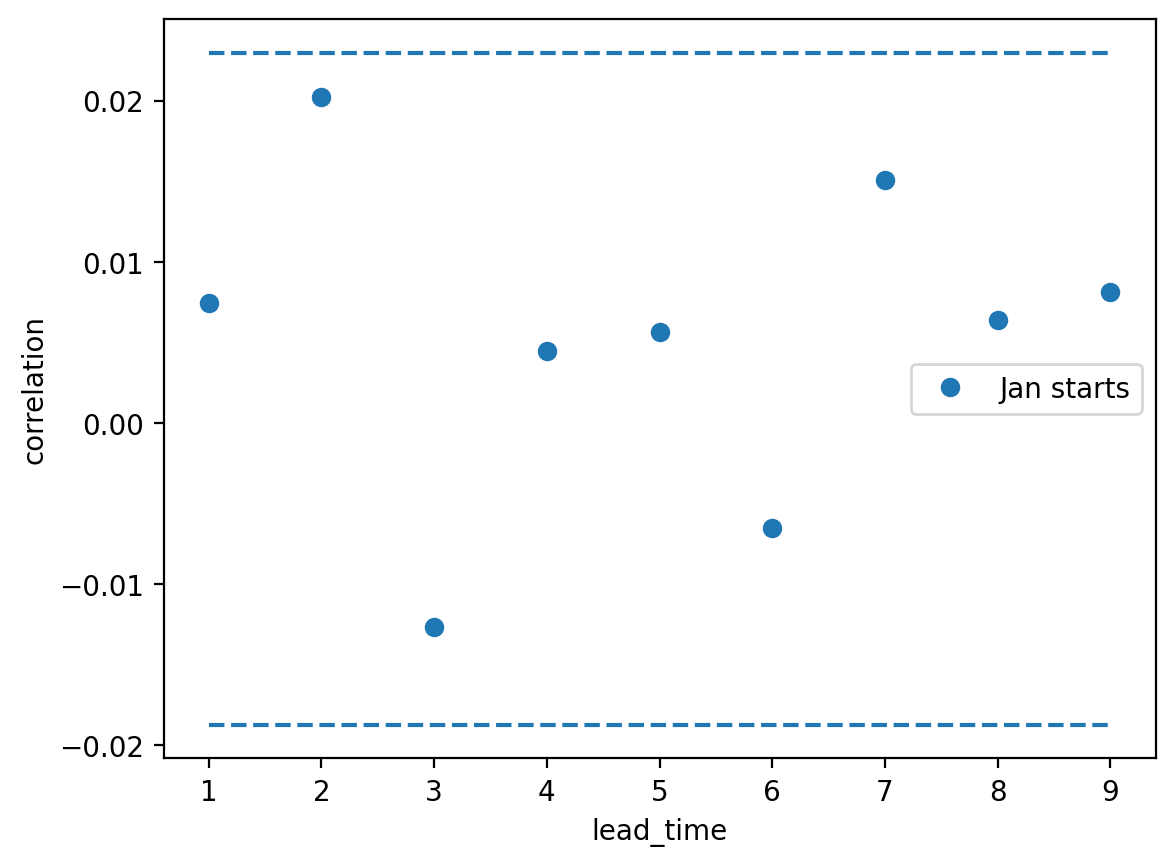

In [17]:
Image(filename=independence_plot)

In [18]:
print(min_lead)

1


In [19]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

In [20]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [21]:
model_da_stacked.shape

(10260,)

In [22]:
model_add_bc_da_stacked = model_add_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [23]:
model_add_bc_da_stacked.shape

(10260,)

In [24]:
model_mulc_bc_da_stacked = model_mulc_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [25]:
model_mulc_bc_da_stacked.shape

(10260,)

### Bias correction and similarity testing

In [26]:
def plot_distributions(include_additive=False):
    """Plot various distributions"""

    fig = plt.figure(figsize=[10, 6])
    gev_xvals = np.arange(0, 500)

    model_da.plot.hist(
        bins=50, density=True, label=model_name, alpha=0.7, facecolor='tab:blue',
    )
    model_gev_shape, model_gev_loc, model_gev_scale = indices.fit_gev(model_da_stacked.values)
    model_gev_pdf = gev.pdf(gev_xvals, model_gev_shape, model_gev_loc, model_gev_scale)
    plt.plot(gev_xvals, model_gev_pdf, color='tab:blue', linewidth=4.0)

    if include_additive:
        model_add_bc_ds['pr'].plot.hist(
            bins=50, density=True, label=f'{model_name} additive bias corrected', facecolor='tab:red', alpha=0.7
        )
        model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale = indices.fit_gev(model_add_bc_da_stacked.values)
        model_add_bc_gev_pdf = gev.pdf(gev_xvals, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)
        plt.plot(gev_xvals, model_add_bc_gev_pdf, color='tab:red', linewidth=4.0)

    model_mulc_bc_ds['pr'].plot.hist(
        bins=50, density=True, label=f'{model_name} multiplicative bias corrected', facecolor='tab:orange', alpha=0.7
    )
    model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale = indices.fit_gev(model_mulc_bc_da_stacked.values)
    model_mulc_bc_gev_pdf = gev.pdf(gev_xvals, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)
    plt.plot(gev_xvals, model_mulc_bc_gev_pdf, color='tab:orange', linewidth=4.0)

    agcd_ds['pr'].plot.hist(
        bins=50, density=True, label='AGCD', facecolor='tab:gray', alpha=0.7
    )
    agcd_gev_shape, agcd_gev_loc, agcd_gev_scale = indices.fit_gev(agcd_ds['pr'].values)
    agcd_gev_pdf = gev.pdf(gev_xvals, agcd_gev_shape, agcd_gev_loc, agcd_gev_scale)
    plt.plot(gev_xvals, agcd_gev_pdf, color='tab:gray', linewidth=4.0)

    plt.xlabel('precipitation (mm)')
    plt.ylabel('probability')
    plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    plt.xlim(0, 500)
    plt.legend()
    if not include_additive:
        outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_{model_name}_{region_name}.png'
        print(outfile)
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    plt.show()

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_CanESM5_east-coast-flood-region.png


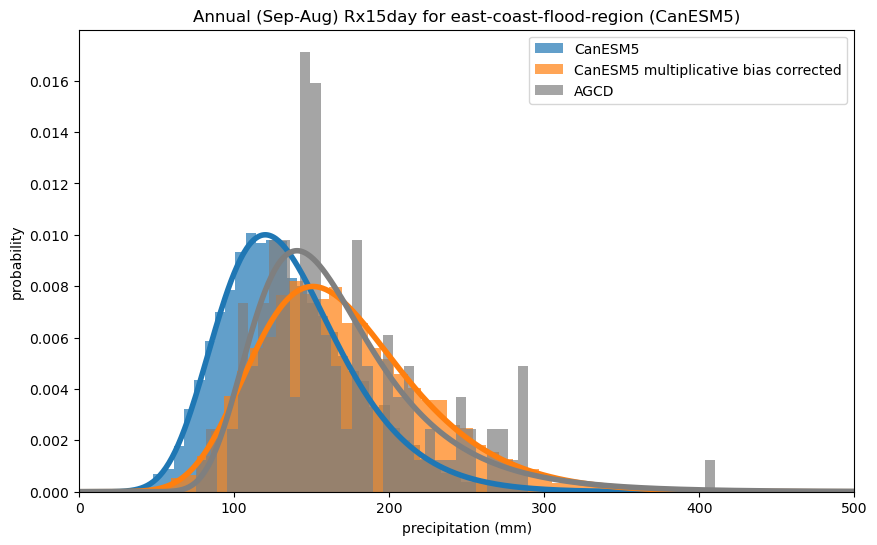

In [27]:
plot_distributions()

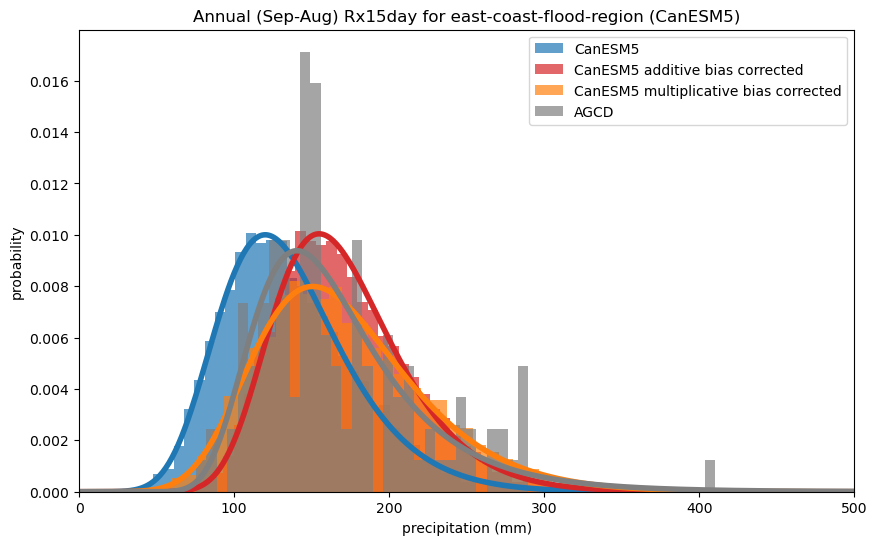

In [28]:
plot_distributions(include_additive=True)

In [27]:
print(f'raw data shape parameter: {model_gev_shape:.3f}')
print(f'raw data location parameter: {model_gev_loc:.3f}') 
print(f'raw data scale parameter: {model_gev_scale:.3f}')

raw data shape parameter: 0.070
raw data location parameter: 117.399
raw data scale parameter: 36.873


In [28]:
print(f'additive corrected shape parameter: {model_add_bc_gev_shape:.3f}')
print(f'additive corrected location parameter: {model_add_bc_gev_loc:.3f}') 
print(f'additive corrected scale parameter: {model_add_bc_gev_scale:.3f}')

additive corrected shape parameter: 0.069
additive corrected location parameter: 152.189
additive corrected scale parameter: 36.729


In [29]:
print(f'multiplicative corrected shape parameter: {model_mulc_bc_gev_shape:.3f}')
print(f'multiplicative corrected location parameter: {model_mulc_bc_gev_loc:.3f}') 
print(f'multiplicative corrected scale parameter: {model_mulc_bc_gev_scale:.3f}')

multiplicative corrected shape parameter: 0.069
multiplicative corrected location parameter: 147.429
multiplicative corrected scale parameter: 46.149


We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [27]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [28]:
similarity_raw_ds['ks_pval'].values

array([1.7429718e-04, 1.4695530e-07, 1.3272067e-05, 1.3272067e-05,
       1.9570916e-05, 1.2313030e-04, 2.3165255e-04, 1.3053347e-04,
       1.8457005e-04], dtype=float32)

In [29]:
similarity_raw_ds['ad_pval'].values

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
      dtype=float32)

In [30]:
similarity_add_bias_ds = fileio.open_dataset(similarity_add_bc_file)

In [31]:
similarity_add_bias_ds['ks_pval'].values

array([0.32683656, 0.14938025, 0.36824667, 0.30355835, 0.3348583 ,
       0.2161872 , 0.16790459, 0.38571122, 0.2046326 ], dtype=float32)

In [32]:
similarity_add_bias_ds['ad_pval'].values

array([0.25      , 0.17906442, 0.25      , 0.25      , 0.25      ,
       0.25      , 0.21638604, 0.25      , 0.18673867], dtype=float32)

In [33]:
similarity_mulc_bias_ds = fileio.open_dataset(similarity_mulc_bc_file)

In [34]:
similarity_mulc_bias_ds['ks_pval'].values

array([0.6718141 , 0.5954469 , 0.6718141 , 0.60629386, 0.60629386,
       0.6718141 , 0.3946323 , 0.7044636 , 0.52105194], dtype=float32)

In [35]:
similarity_mulc_bias_ds['ad_pval'].values

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
      dtype=float32)

### Exceedance curves

In [36]:
def plot_exceedance(sample_ds, model_name, outfile=None):
    """Plot single exceedance curve"""
    
    sorted_data, exceedance_data = general_utils.exceedance_curve(sample_ds)
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    ax.plot(sorted_data, exceedance_data)
    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.axvline(pr2022, color='0.5', linestyle='--')
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
        print(outfile)
    else:
        plt.show()

In [37]:
def gev_event_likelihood(event, shape, loc, scale):
    """Get likelihood stats for an event from a GEV fit"""

    probability = gev.sf(event, shape, loc=loc, scale=scale)
    return_period = 1. / probability
    percentile = (1 - probability) * 100
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period\n')

In [38]:
def plot_exceedance_by_decade(sample_ds, model_name):
    """Plot exceedance curve by decade"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    if model_name == 'CAFE':
        start_years = [1995, 2000, 2005, 2010, 2015]
        step = 4
    else:
        start_years = [1960, 1970, 1980, 1990, 2000, 2010]
        step = 9
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + step
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-25'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        sorted_data, exceedance_data = general_utils.exceedance_curve(ds_selection)
        n_years = len(sorted_data)
        label = f'{start_year}-{end_year} ({n_years} samples)'
        color = next(colors)
        ax.plot(sorted_data, exceedance_data, label=label, color=color)
    
        print(f'{start_year}-{end_year}')
        n_events, n_population, return_period, percentile = general_utils.event_in_context(ds_selection.values, pr2022, 'above')
        print(f'{n_events} events in {n_population} samples')
        print(f'{percentile:.2f}% percentile')
        print(f'{return_period:.0f} year return period')
        print('GEV:')
        gev_shape, gev_loc, gev_scale = indices.fit_gev(ds_selection.values)
        gev_event_likelihood(pr2022, gev_shape, gev_loc, gev_scale)

    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.legend()
    ax.axvline(pr2022, color='0.5', linestyle='--')
#    outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}_by-decade.png'
#    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    plt.show()
#    print(outfile)

#### Additive bias corrected data

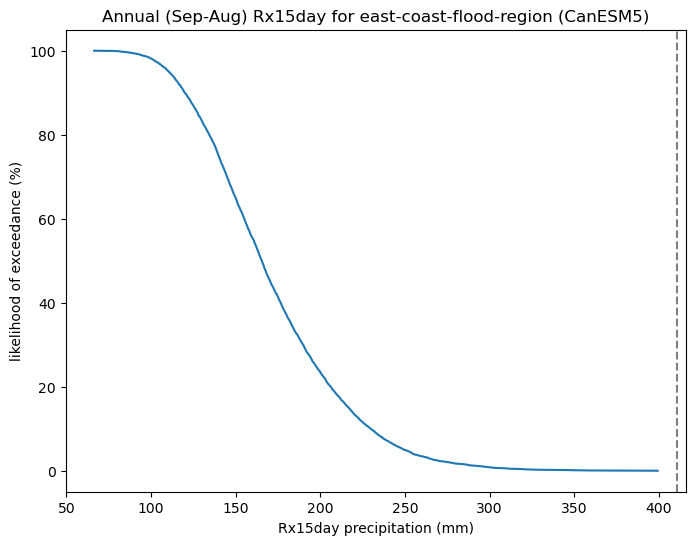

In [39]:
#outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}.png'
plot_exceedance(model_add_bc_da_stacked, model_name)#, outfile=outfile)

In [40]:
n_events_add_bc, n_population_add_bc, return_period_add_bc, percentile_add_bc = general_utils.event_in_context(model_add_bc_da_stacked.values, pr2022, 'above')
print('ADDITIVE BIAS CORRECTED DATA')
print(f'{n_events_add_bc} events in {n_population_add_bc} samples')
print(f'{percentile_add_bc:.2f}% percentile')
print(f'{return_period_add_bc:.0f} year return period')

ADDITIVE BIAS CORRECTED DATA
0 events in 10260 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


In [41]:
print('ADDITIVE BIAS CORRECTED GEV')
gev_event_likelihood(pr2022, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)

ADDITIVE BIAS CORRECTED GEV
99.99% percentile
14700 year return period



#### Multiplicative bias corrected data

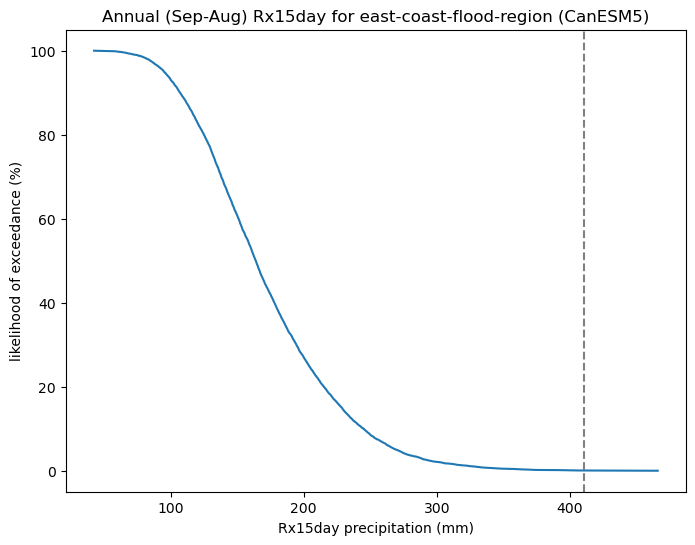

In [42]:
plot_exceedance(model_mulc_bc_da_stacked, model_name)

In [43]:
n_events_mulc_bc, n_population_mulc_bc, return_period_mulc_bc, percentile_mulc_bc = general_utils.event_in_context(model_add_bc_da_stacked.values, pr2022, 'above')
print('MULTIPLICATIVE BIAS CORRECTED DATA')
print(f'{n_events_mulc_bc} events in {n_population_mulc_bc} samples')
print(f'{percentile_mulc_bc:.2f}% percentile')
print(f'{return_period_mulc_bc:.0f} year return period')

MULTIPLICATIVE BIAS CORRECTED DATA
0 events in 10260 samples
100.00% percentile
inf year return period


In [44]:
print('MULTIPLICATIVE BIAS CORRECTED GEV')
gev_event_likelihood(pr2022, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)

MULTIPLICATIVE BIAS CORRECTED GEV
99.93% percentile
1377 year return period



1960-1969


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 720 samples
100.00% percentile
inf year return period
GEV:
99.94% percentile
1704 year return period

1970-1979
2 events in 1800 samples
99.89% percentile
900 year return period
GEV:
99.95% percentile
1881 year return period

1980-1989
1 events in 1800 samples
99.94% percentile
1800 year return period
GEV:
99.97% percentile
3217 year return period

1990-1999
1 events in 1800 samples
99.94% percentile
1800 year return period
GEV:
99.93% percentile
1349 year return period

2000-2009


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 1800 samples
100.00% percentile
inf year return period
GEV:
100.00% percentile
347949 year return period

2010-2019
2 events in 1780 samples
99.89% percentile
890 year return period
GEV:
99.84% percentile
616 year return period



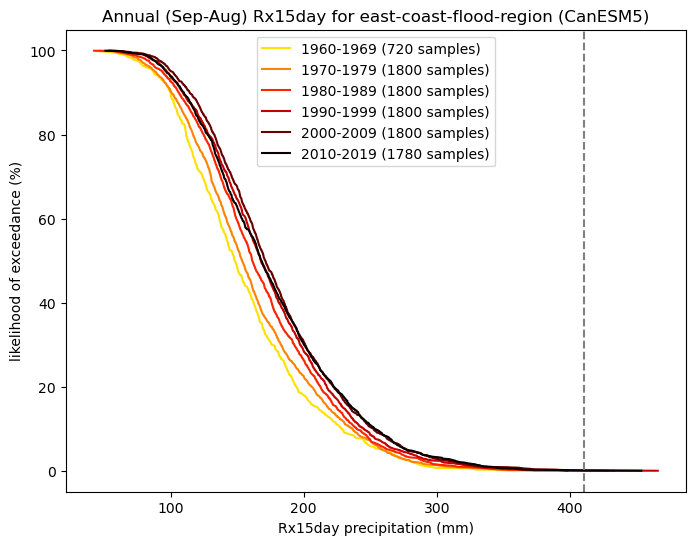

In [45]:
plot_exceedance_by_decade(model_mulc_bc_da_stacked, model_name)

#### Raw data

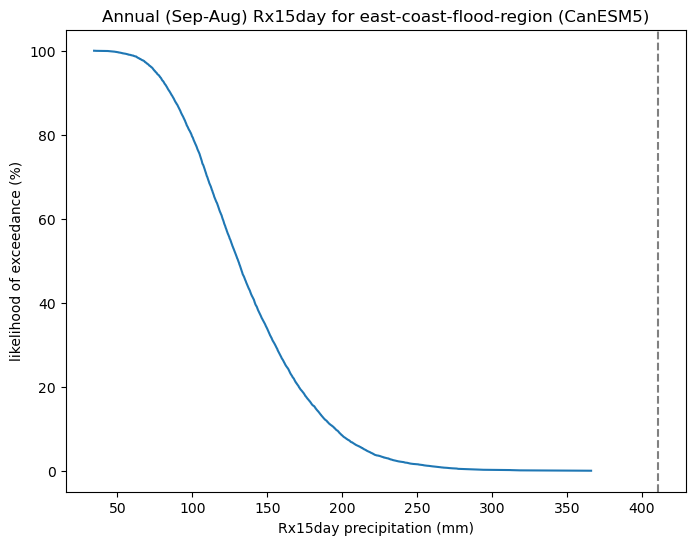

In [46]:
plot_exceedance(model_da_stacked, model_name)

In [47]:
n_events, n_population, return_period, percentile = general_utils.event_in_context(model_da_stacked.values, pr2022, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
0 events in 10260 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


In [48]:
print('RAW GEV')
gev_event_likelihood(pr2022, model_gev_shape, model_gev_loc, model_gev_scale)

RAW GEV
100.00% percentile
111366 year return period



### Seasonality

In [62]:
model_df = model_da_stacked.to_dataframe()
model_df = model_df.dropna()

In [50]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

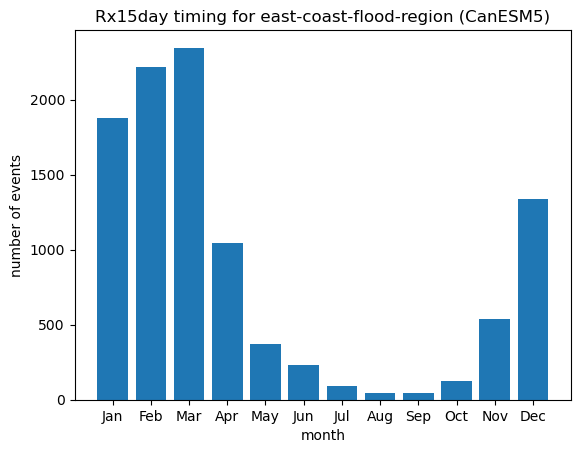

In [51]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
#plt.savefig(
#    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
#    bbox_inches='tight',
#    facecolor='white',
#    dpi=dpi
#)
plt.show()

### Relationship with ENSO

In [52]:
nino_ds = fileio.open_dataset(nino_file)
nino_ds = nino_ds.assign_coords({'init_date': [date.strftime('%Y%m') for date in nino_ds['init_date'].values]})
nino_ds

<xarray.Dataset>
Dimensions:    (init_date: 57, ensemble: 20, lead_time: 120)
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 8 ... 11 12 13 14 15 16 17 18 19
  * init_date  (init_date) <U6 '196101' '196201' '196301' ... '201601' '201701'
    time       (lead_time, init_date) object dask.array<chunksize=(120, 57), meta=np.ndarray>
Data variables:
    tos        (init_date, ensemble, lead_time) float32 dask.array<chunksize=(57, 20, 120), meta=np.ndarray>
Attributes:
    history:  Fri Mar 03 13:05:37 2023: /g/data/xv83/dbi599/miniconda3/envs/u...

In [53]:
nino_values = []
for index, row in model_df.iterrows():
    event_init_date = row['init_date'].strftime('%Y%m')
    event_ensemble = row['ensemble']
    event_year_month = row['time'].strftime('%Y-%m')
    nino_selection = nino_ds.sel({'init_date': event_init_date, 'ensemble': event_ensemble})
    nino_selection = nino_selection.swap_dims({'lead_time': 'time'})
    nino_year_month = [date.strftime('%Y-%m') for date in nino_selection['time'].values]
    nino_selection = nino_selection.assign_coords({'time': nino_year_month})
    nino_value = float(nino_selection['tos'].sel({'time': event_year_month}).values)
    nino_values.append(nino_value)

In [54]:
model_df['nino34'] = nino_values

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


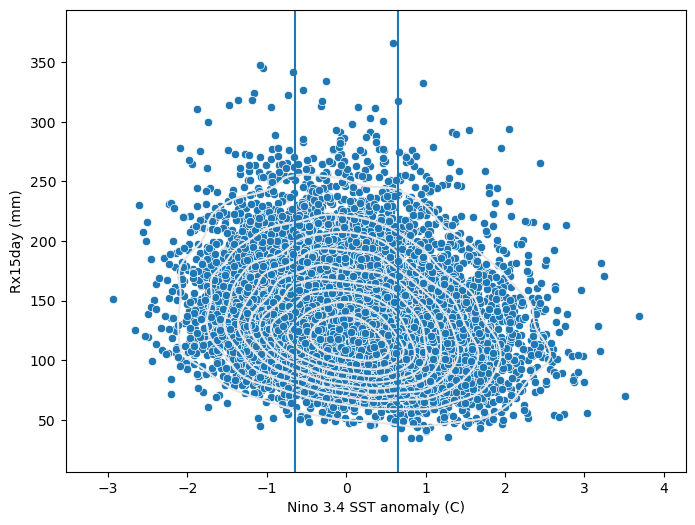

In [55]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.scatterplot(ax=ax, data=model_df, x='nino34', y='pr')
sns.kdeplot(ax=ax, data=model_df, x='nino34', y='pr', color='0.9', linewidth=1)

ax.set_ylabel('Rx15day (mm)')
ax.set_xlabel('Nino 3.4 SST anomaly (C)')
ax.axvline(0.65)
ax.axvline(-0.65)
plt.show()

### Meteorology

In [56]:
def plot_average(start_date, end_date, color_da=None, color_var=None, contour_da=None, contour_var=None):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var:
        if color_var == 'pr':
            levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
            label = 'total precipitation (mm)'
            cmap = cmocean.cm.rain
            extend = 'max'
        elif color_var == 'ua300':
            levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
            label = '300hPa zonal wind'
            cmap='RdBu_r'
            extend = 'both'
        else:
            raise ValueError('Invalid color variable')
        color_da.plot(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            levels=levels,
            extend=extend,
            cbar_kwargs={'label': label},
        )
    
    if contour_var:
        if contour_var == 'z500':
            levels = np.arange(5000, 6300, 50)
        elif contour_var == 'psl':
            levels = np.arange(900, 1100, 2.5)
        elif contour_var == 'ua300':
            levels = np.arange(15, 60, 5)
        else:
            raise ValueError('Invalid contour variable')
        lines = contour_da.plot.contour(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    if contour_var:
        ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    else:
        ax1.set_title(f'{start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [57]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)
ranked_events.head(n=10)

,,,event_time,time,ensemble,init_date,lead_time,pr,nino34
ensemble,init_date,lead_time,,,,,,,
3,2007-01-01 00:00:00,6,2013-03-04,2013-01-01 12:00:00,3,2007-01-01 00:00:00,6,365.992317,0.583496
4,1996-01-01 00:00:00,2,1998-02-01,1998-01-01 12:00:00,4,1996-01-01 00:00:00,2,347.704310,-1.081703
1,1966-01-01 00:00:00,5,1971-02-27,1971-01-01 12:00:00,1,1966-01-01 00:00:00,5,345.090720,-1.051416
2,1977-01-01 00:00:00,5,1982-02-05,1982-01-01 12:00:00,2,1977-01-01 00:00:00,5,341.560607,-0.672434
18,1972-01-01 00:00:00,3,1975-02-06,1975-01-01 12:00:00,18,1972-01-01 00:00:00,3,333.968198,-0.253223
16,2008-01-01 00:00:00,7,2015-03-04,2015-01-01 12:00:00,16,2008-01-01 00:00:00,7,332.670621,0.970613
15,2007-01-01 00:00:00,7,2013-12-28,2014-01-01 12:00:00,15,2007-01-01 00:00:00,7,326.524429,-0.546982
8,1987-01-01 00:00:00,5,1992-03-12,1992-01-01 12:00:00,8,1987-01-01 00:00:00,5,324.287687,-1.160709
13,1999-01-01 00:00:00,1,2000-02-06,2000-01-01 12:00:00,13,1999-01-01 00:00:00,1,322.712786,-0.728737


In [58]:
model_add_bc_df = model_add_bc_ds['pr'].to_dataframe()
model_add_bc_df = model_add_bc_df.dropna()
model_add_bc_df = model_add_bc_df.reset_index()
ranked_add_bc_events = model_add_bc_df.sort_values(by=['pr'], ascending=False)
ranked_add_bc_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr
8312,2007-01-01 00:00:00,3,6,2013-03-04,2013-01-01 12:00:00,399.242657
6337,1996-01-01 00:00:00,4,2,1998-02-01,1998-01-01 12:00:00,391.232921
913,1966-01-01 00:00:00,1,5,1971-02-27,1971-01-01 12:00:00,379.813840
2902,1977-01-01 00:00:00,2,5,1982-02-05,1982-01-01 12:00:00,376.283727
2144,1972-01-01 00:00:00,18,3,1975-02-06,1975-01-01 12:00:00,369.183111
8610,2008-01-01 00:00:00,16,7,2015-03-04,2015-01-01 12:00:00,366.040193
8421,2007-01-01 00:00:00,15,7,2013-12-28,2014-01-01 12:00:00,359.894001
4756,1987-01-01 00:00:00,8,5,1992-03-12,1992-01-01 12:00:00,359.010807
6957,1999-01-01 00:00:00,13,1,2000-02-06,2000-01-01 12:00:00,354.934984
624,1964-01-01 00:00:00,9,4,1968-02-16,1968-01-01 12:00:00,353.388970


In [59]:
model_mulc_bc_df = model_mulc_bc_ds['pr'].to_dataframe()
model_mulc_bc_df = model_mulc_bc_df.dropna()
model_mulc_bc_df = model_mulc_bc_df.reset_index()
ranked_mulc_bc_events = model_mulc_bc_df.sort_values(by=['pr'], ascending=False)
ranked_mulc_bc_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr
6337,1996-01-01 00:00:00,4,2,1998-02-01,1998-01-01 12:00:00,466.037506
8312,2007-01-01 00:00:00,3,6,2013-03-04,2013-01-01 12:00:00,453.683467
913,1966-01-01 00:00:00,1,5,1971-02-27,1971-01-01 12:00:00,432.867232
2902,1977-01-01 00:00:00,2,5,1982-02-05,1982-01-01 12:00:00,428.439207
2144,1972-01-01 00:00:00,18,3,1975-02-06,1975-01-01 12:00:00,421.443242
8610,2008-01-01 00:00:00,16,7,2015-03-04,2015-01-01 12:00:00,413.236878
4756,1987-01-01 00:00:00,8,5,1992-03-12,1992-01-01 12:00:00,406.772785
8421,2007-01-01 00:00:00,15,7,2013-12-28,2014-01-01 12:00:00,405.602200
624,1964-01-01 00:00:00,9,4,1968-02-16,1968-01-01 12:00:00,401.677735
7519,2002-01-01 00:00:00,15,5,2007-01-27,2007-01-01 12:00:00,398.186606


2006 (2013-03-04), ensemble: r4, 365.992316591472mm


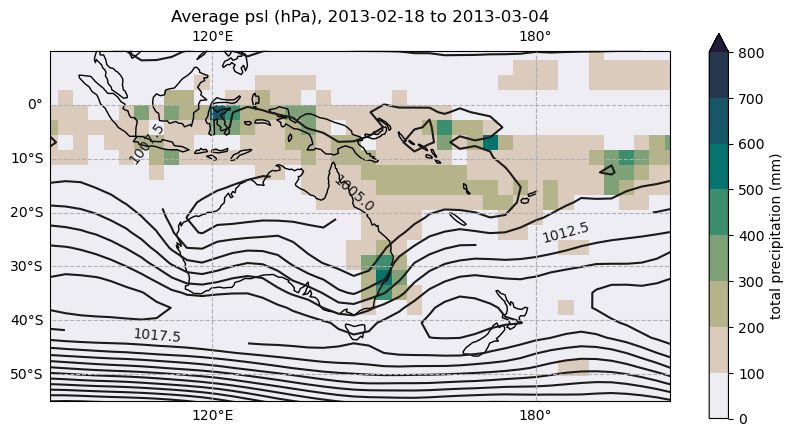

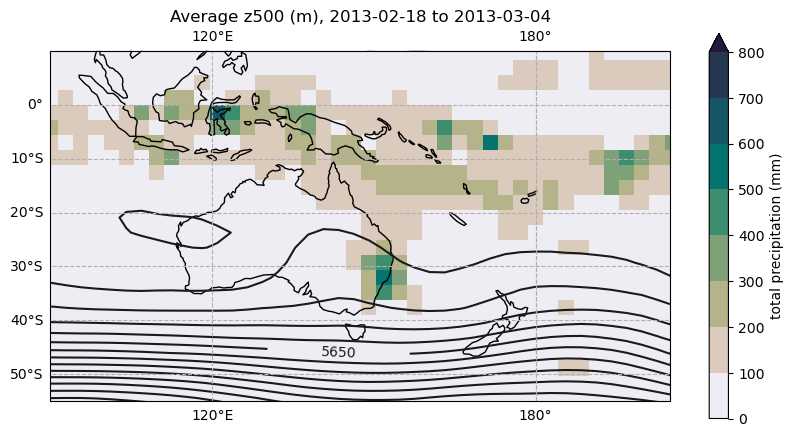

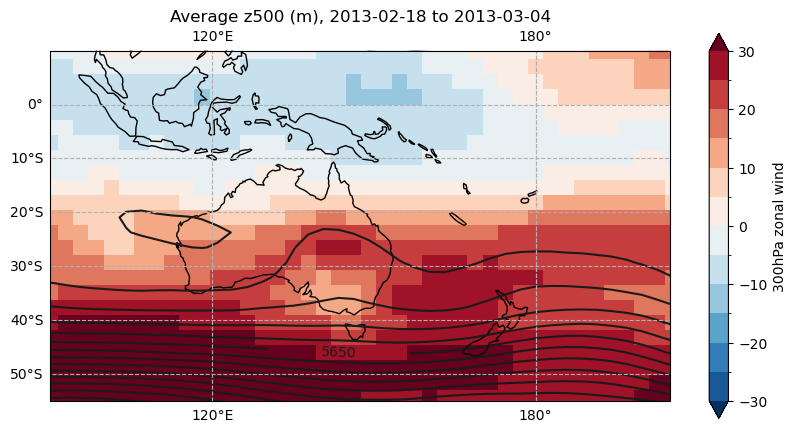

1995 (1998-02-01), ensemble: r5, 347.704309584546mm


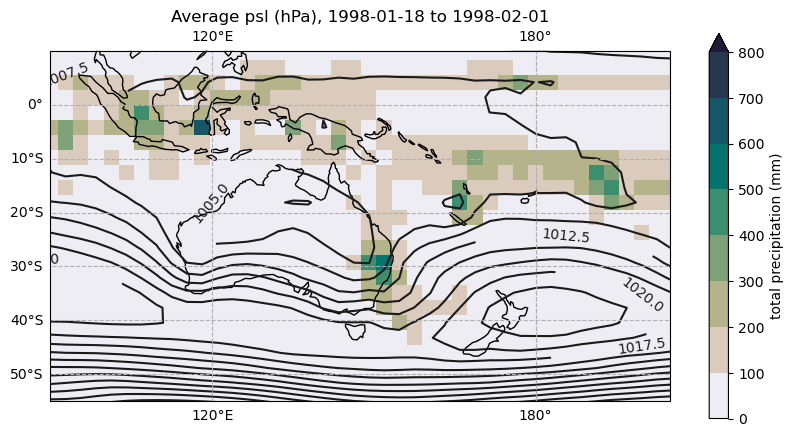

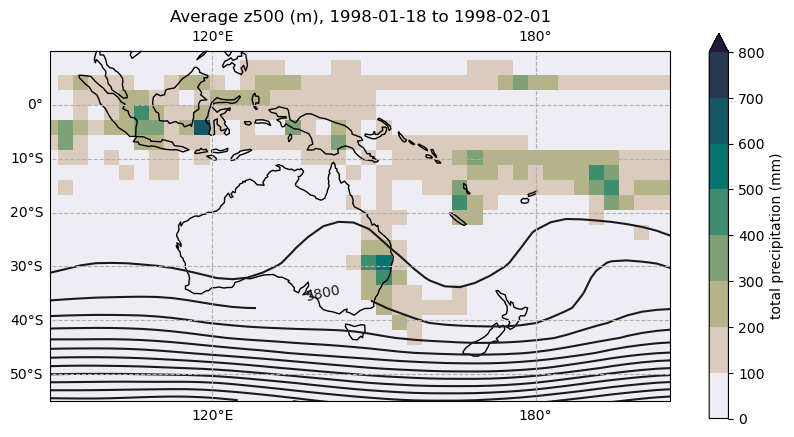

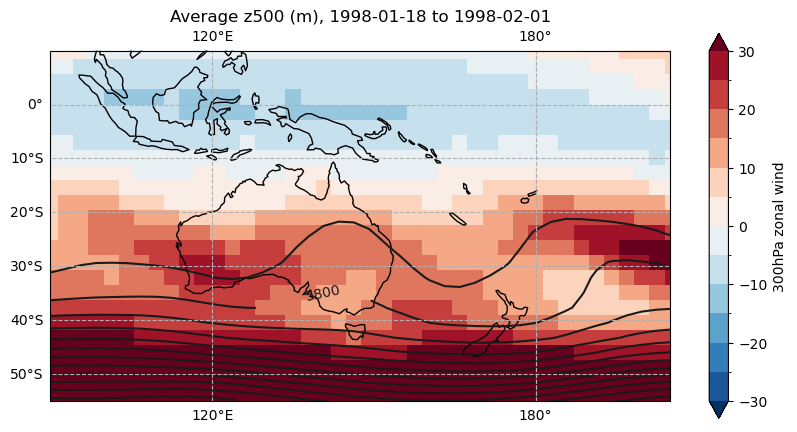

1965 (1971-02-27), ensemble: r2, 345.0907202690974mm


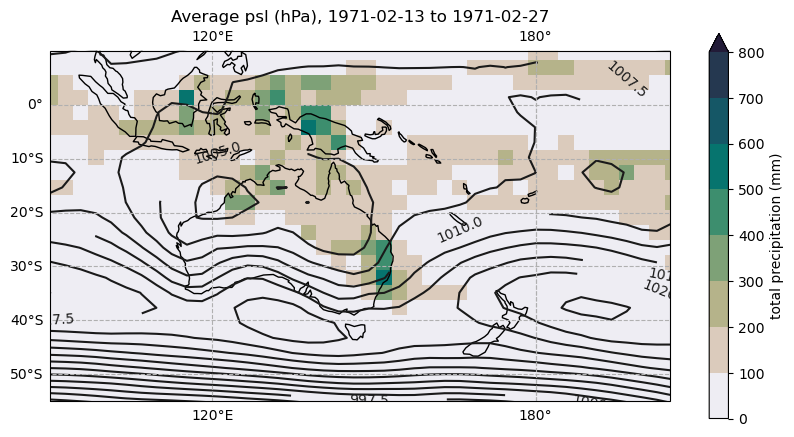

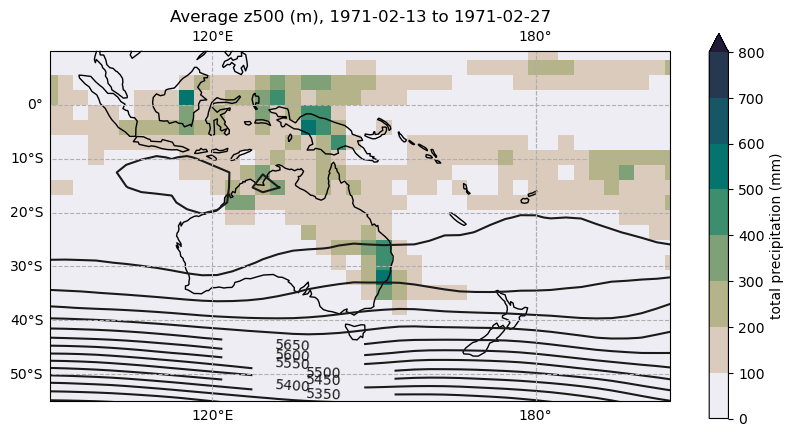

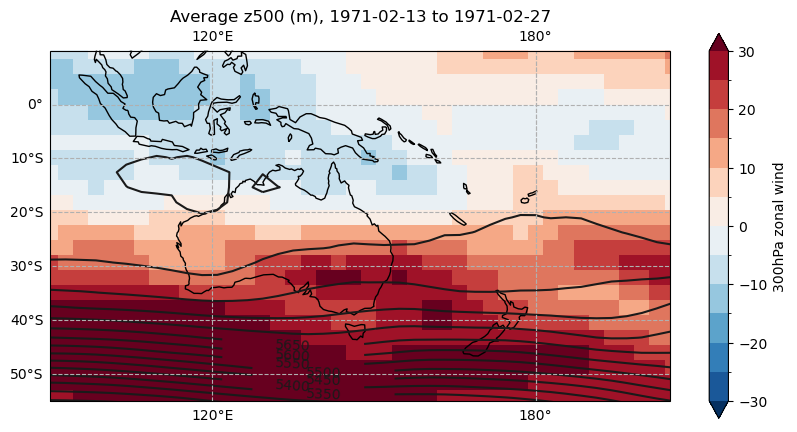

1976 (1982-02-05), ensemble: r3, 341.56060746484184mm


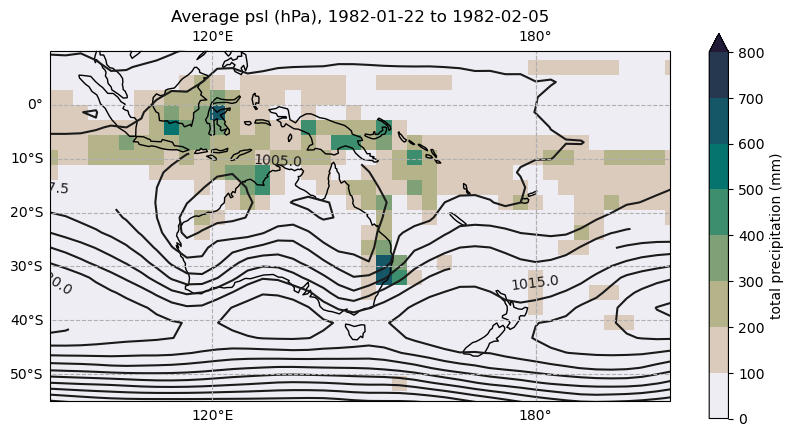

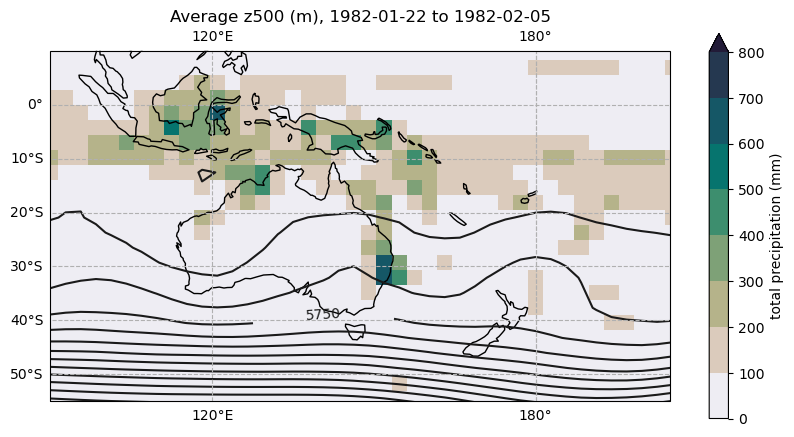

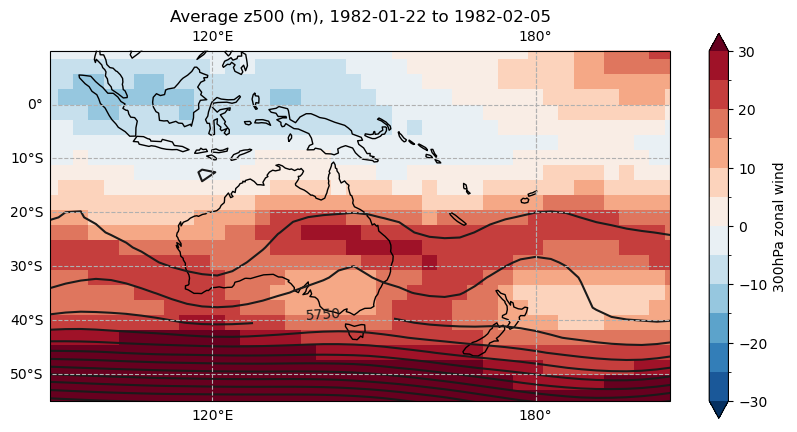

In [60]:
for index, row in ranked_events.head(n=4).iterrows():
    init_date = int(row['init_date'].strftime('%Y')) - 1
    ensemble = int(row['ensemble']) + 1
    end_date = row['event_time']
    rx_value = row['pr']
    print(f'{init_date} ({end_date}), ensemble: r{ensemble}, {rx_value}mm')
    
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    
    pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/pr/*/*/*.nc')
    pr_files.sort()
    ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
    
    psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/psl/*/*/*.nc')
    psl_files.sort()
    ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
    
    zg_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/zg/*/*/*.nc')
    zg_files.sort()
    ds_zg = fileio.open_dataset(zg_files, variables=['zg'],)
    
    ua_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/ua/*/*/*.nc')
    ua_files.sort()
    ds_ua = fileio.open_dataset(ua_files, variables=['ua'],)

    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')
    zg_da = ds_zg.sel({'time': slice(start_date, end_date)})['zg']
    z500_da = zg_da.sel({'plev': 50000}, method='nearest')
    ua_da = ds_ua.sel({'time': slice(start_date, end_date)})['ua']
    ua300_da = ua_da.sel({'plev': 30000}, method='nearest')

    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
    z500_da_mean = z500_da.mean('time', keep_attrs=True)
    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

    plot_average(start_date, end_date, pr_da_sum, 'pr', psl_da_mean, 'psl')
    plot_average(start_date, end_date, pr_da_sum, 'pr', z500_da_mean, 'z500')
    plot_average(start_date, end_date, ua300_da_mean, 'ua300', z500_da_mean, 'z500')